In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import jax
import jax.numpy as jnp
from scipy.stats import qmc

os.chdir('/mnt/home/sliu1/normalizing_flows')
from qmc_flow.models.tqmc import TransportQMC
from qmc_flow.targets import StanModel, Gaussian
from qmc_flow.utils import get_effective_sample_size, get_moments
rootdir = '/mnt/home/sliu1/ceph/normalizing_flows/qmc_flow'

MACHINE_EPSILON = np.finfo(np.float64).eps


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
d = 20
N = 50
cov_x = 'low_rank'
rho = 3
date = '2024-09-25'
num_composition = 1
max_deg = 3
max_iter = 400
path = os.path.join(rootdir, date, 'logistic')
ntrain = 2**8
mses = None

# filename = os.path.join(path, f'{cov_x}_d_{d}_N_{N}_ntrain_{ntrain}_comp_{num_composition}_deg_{max_deg}_iter_{max_iter}_seed_{seed}.pkl')
filename = os.path.join(path, f'regkl_d_{d}_N_{N}_{cov_x}_{rho}_n_{ntrain}_comp_{num_composition}_deg_{max_deg}_lbfgs_iter_{max_iter}_lr_1.0.pkl')

with open(filename, 'rb') as f:
    results = pickle.load(f)
df = pd.DataFrame(results['test_results']['mse']).T.reset_index(names=['sampler', 'm', 'seed'])
df.set_index(['sampler', 'm', 'seed'], inplace=True)
df_IS = pd.DataFrame(results['test_results']['mse_IS']).T.reset_index(names=['sampler', 'm', 'seed'])
df_IS.set_index(['sampler', 'm', 'seed'], inplace=True)

In [5]:
df_IS

0             1             2             3   \
sampler m  seed                                                           
mc      3  0     1.510091e-02  1.191663e-01  2.151008e-01  7.845943e-02   
rqmc    3  0     6.029435e-04  3.083977e-04  5.622441e-03  1.144655e-02   
rqmc_as 3  0     1.181678e-02  3.466679e-03  3.829193e-04  5.454509e-03   
mc      4  0     6.135675e-03  3.619921e-02  6.318680e-03  3.049273e-02   
rqmc    4  0     3.647119e-04  1.401564e-03  6.189381e-05  5.696427e-03   
...                       ...           ...           ...           ...   
        12 49    1.103899e-06  4.936894e-06  1.475498e-07  3.112984e-05   
rqmc_as 12 49    2.273168e-07  5.254927e-05  3.183700e-05  5.013338e-08   
mc      13 49    7.750584e-05  8.460064e-05  1.085527e-04  7.386514e-05   
rqmc    13 49    4.373080e-05  1.341956e-05  1.933444e-05  1.732583e-05   
rqmc_as 13 49    7.109683e-06  7.021634e-07  6.038775e-07  5.190786e-09   

                           4             5             6             7   \
sampler m  seed                                                           
mc      3  0     3.940467e-02  7.502075e-02  6.085797e-04  1.647991e-01   
rqmc    3  0     1.502782e-02  8.079260e-04  1.234223e-03  1.032003e-03   
rqmc_as 3  0     5.038799e-03  2.127069e-04  1.447081e-04  4.186002e-03   
mc      4  0     6.795568e-05  9.040172e-02  1.956979e-01  3.456287e-03   
rqmc    4  0     1.484613e-04  4.390891e-04  1.293570e-04  5.214603e-03   
...                       ...           ...           ...           ...   
        12 49    3.694613e-07  1.086550e-07  6.177124e-07  2.237080e-07   
rqmc_as 12 49    6.963791e-05  1.109068e-05  7.914207e-06  1.120588e-08   
mc      13 49    6.373226e-06  1.911068e-05  4.210839e-05  2.713134e-05   
rqmc    13 49    4.741461e-09  1.252070e-05  8.064104e-07  2.057640e-05   
rqmc_as 13 49    9.946367e-06  3.827310e-06  1.035626e-05  1.242913e-06   

                       8             9   ...            30            31  \
sampler m  seed                          ...                               
mc      3  0     0.035245  9.572197e-02  ...  1.383814e-02  1.734247e-02   
rqmc    3  0     0.000284  5.619034e-03  ...  1.824440e-01  1.827200e-01   
rqmc_as 3  0     0.060130  2.394632e-02  ...  3.802286e-02  1.421878e-01   
mc      4  0     0.000147  2.470039e-01  ...  3.504003e-02  3.476100e-02   
rqmc    4  0     0.001118  1.354510e-03  ...  1.876935e-06  3.630320e-02   
...                   ...           ...  ...           ...           ...   
        12 49    0.000005  4.935172e-07  ...  1.352786e-05  2.755600e-07   
rqmc_as 12 49    0.000002  1.794866e-06  ...  1.043362e-04  3.114447e-05   
mc      13 49    0.000073  6.434393e-05  ...  6.335453e-04  1.193464e-04   
rqmc    13 49    0.000007  3.601605e-06  ...  1.510749e-04  1.868289e-06   
rqmc_as 13 49    0.000003  1.808744e-05  ...  2.148213e-08  2.414316e-05   

                       32        33        34        35            36  \
sampler m  seed                                                         
mc      3  0     0.985220  0.000074  0.000220  0.036368  4.043685e-02   
rqmc    3  0     0.042778  0.319454  0.303493  0.048922  1.052059e-01   
rqmc_as 3  0     0.006611  0.093128  0.077465  0.217002  5.331778e-03   
mc      4  0     0.066850  0.004542  0.109268  0.016407  1.232208e-01   
rqmc    4  0     0.029748  0.002026  0.398974  0.454347  1.895903e-02   
...                   ...       ...       ...       ...           ...   
        12 49    0.000041  0.000013  0.000123  0.000014  4.510003e-07   
rqmc_as 12 49    0.000003  0.000113  0.000020  0.000114  1.611040e-05   
mc      13 49    0.000006  0.003063  0.000098  0.000042  8.611731e-06   
rqmc    13 49    0.000001  0.000016  0.000041  0.000079  4.740886e-08   
rqmc_as 13 49    0.000013  0.000028  0.000004  0.000009  2.430540e-06   

                           37            38            39  
sampler m  seed                                            
mc      3  0    

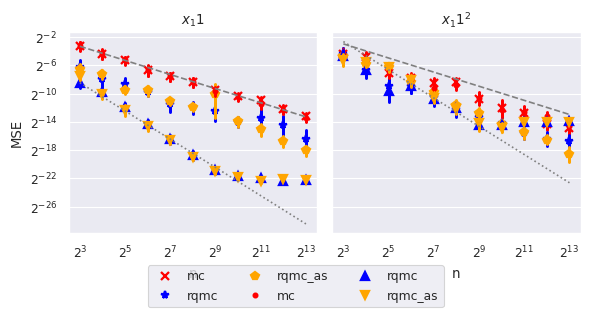

In [16]:
j = 10
color_list = {'mc': 'red', 'rqmc': 'blue', 'rqmc_as': 'orange'}
sns.set_theme(context='paper', style='darkgrid', font_scale=1.)
fig, ax = plt.subplots(1, 2, figsize=(3*2, 3), sharey=True)
for var_idx in [0, 1]:
    col_idx = j + var_idx * d
    sns.pointplot(ax=ax[var_idx], data=df_IS, x='m', y=col_idx, hue='sampler', markers=['x', '*', 'p'], palette=color_list, linestyles='')
    sns.pointplot(ax=ax[var_idx], data=df, x='m', y=col_idx, hue='sampler', markers=['.', '^', 'v'], palette=color_list, linestyles='')
    m_list = np.arange(3, 14)
    l1 = 1 / 2**m_list
    l1 = l1 / l1[0] * df.xs('mc', level='sampler').xs(3, level='m').loc[:, col_idx].mean()
    l2 = 1 / (4**m_list)
    l2 = l2 / l2[0] * df.xs('rqmc', level='sampler').xs(3, level='m').loc[:, col_idx].mean()
    ax[var_idx].plot(m_list - 3, l1, ls='--', c='gray')
    ax[var_idx].plot(m_list - 3, l2, ls=':', c='gray')
    ax[var_idx].set_yscale('log', base=2)
    ax[var_idx].legend().remove()
    ax[var_idx].set_xticks(np.arange(0, len(m_list), 2))
    ax[var_idx].set_xticklabels([r"$2^{{{:.0f}}}$".format(m) for m in np.arange(3, 14, 2)])
    ax[var_idx].set_xlabel('n')
    if var_idx == 0:
        ax[var_idx].set_title(f'$x_{j+1}$')
    else:
        ax[var_idx].set_title(f'$x_{j+1}^2$')
    ax[var_idx].set_ylabel('MSE')

handles, labels = ax[0].get_legend_handles_labels()
# labels = ['MC+IS', 'RQMC+IS', 'MC', 'RQMC']
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))
plt.tight_layout()
# plt.savefig(f'qmc_flow/plots/2024-09-22/logistic_mse_{cov_x}_d_{d}_N_{N}_ntrain_{ntrain}_var_{j}_comp_{num_composition}_deg_{max_deg}_lbfgs_iter_{max_iter}.pdf', bbox_inches='tight')

In [149]:
def make_plot(cov_x, d, N, saveplot=False, showplot=False):
    moments_1 = None
    moments_2 = None
    num_composition = 1
    max_deg = 5
    max_iter = 200
    ntrain = 64
    date = '2024-09-22'
    path = os.path.join(rootdir, date, 'logistic', 'mse')
    for seed in range(50):
        # filename = os.path.join(path, f'{cov_x}_d_{d}_N_{N}_ntrain_{ntrain}_comp_{num_composition}_deg_{max_deg}_iter_{max_iter}_seed_{seed}.pkl')
        filename = os.path.join(path, f'{cov_x}_d_{d}_N_{N}_ntrain_{ntrain}_sweeping_seed_{seed}.pkl')
        if not os.path.exists(filename):
            continue
        with open(filename, 'rb') as f:
            results = pickle.load(f)
        if moments_1 is None:
            moments_1 = results['moments_1_IS']
            moments_2 = results['moments_2']
        else:
            moments_1 = pd.concat([moments_1, results['moments_1_IS']])
            moments_2 = pd.concat([moments_2, results['moments_2']])
    stds_1 = moments_1.groupby(['m', 'sampler']).std()
    stds_2 = moments_2.groupby(['m', 'sampler']).std()
    d = stds_1.shape[1] - 1
    color_list = {'mc': 'red', 'rqmc': 'blue'}
    sns.set_theme(context='talk', style='darkgrid', font_scale=1.)
    stds = stds_1
    m_list = np.arange(3, 16)
    fig, ax = plt.subplots(1, 4, figsize=(3 * 4, 2.5), sharey=True)
    for var_idx in range(4):
        sns.pointplot(ax=ax[var_idx], data=stds, x='m', y=var_idx, hue='sampler', markers=['.', '*'], palette=color_list, linestyles='')
        
        l1 = 1 / np.sqrt(2**m_list)
        l1 = l1 / l1[0] * stds.loc[stds.index == (3, 'mc')][var_idx].item()
        l2 = 1 / (2**m_list)
        l2 = l2 / l2[0] * stds.loc[stds.index == (3, 'rqmc')][var_idx].item()
        ax[var_idx].plot(m_list - 3, l1, ls='--', c='gray')
        ax[var_idx].plot(m_list - 3, l2, ls=':', c='gray')
        ax[var_idx].set_yscale('log', base=2)
        if var_idx > 0:
            ax[var_idx].legend().remove()
        else:
            handles, labels = ax[var_idx].get_legend_handles_labels()
            labels = ['MC', 'RQMC']
            ax[var_idx].legend(handles, labels, title='', frameon=False, loc='lower left')

        ax[var_idx].set_xticks(np.arange(0, 13, 3))
        ax[var_idx].set_xticklabels([r"$2^{{{:.0f}}}$".format(m) for m in np.arange(3, 16, 3)])
        ax[var_idx].set_xlabel('n')
        ax[var_idx].set_title(f'$x_{var_idx + 1}$')
        ax[var_idx].set_ylabel('Std. Err.')
        # fig.suptitle(name, y=1.1)
    # if saveplot:
    #     plt.savefig(f'qmc_flow/plots/2024-09-16/moment1_std_{name}_ntrain_{ntrain}_comp_{num_composition}_deg_{max_deg}_iter_{max_iter}.pdf', bbox_inches='tight')
    # if showplot:
    #     plt.show()
    # else:
    #     plt.close()

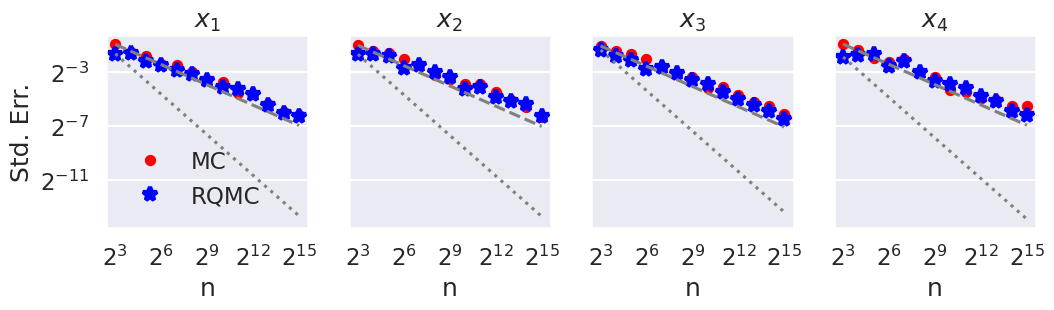

In [150]:
make_plot('equi', d=50, N=50, saveplot=False, showplot=True)

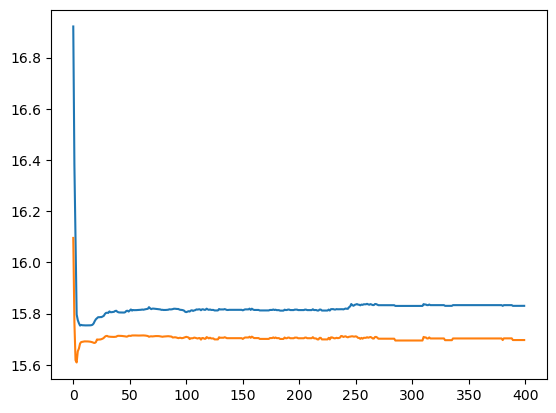

In [15]:
cov_x = 'ar1'
if cov_x == 'equi':
    rho = 0.7
elif cov_x == 'ar1':
    rho = 0.9

d = 5
N = 20
num_comp = 3
deg = 5
optimizer = 'lbfgs'
lr = 1.
max_iter = 400
seed = 2
path = '/mnt/home/sliu1/ceph/normalizing_flows/qmc_flow/2024-09-22/logistic'
filename = os.path.join(path, f'logistic_d_{d}_N_{N}_{cov_x}_{rho}_n_64_comp_{num_comp}_deg_{deg}_{optimizer}_iter_{max_iter}_lr_{lr}_{seed}.pkl')

with open(filename, 'rb') as f:
    res = pickle.load(f)

plt.plot(res['rkl'])
plt.plot(res['chisq'] * (-0.5))

In [37]:
res['max_ess'], res['ess'][-1]

(Array(23.405388, dtype=float32), Array(8.445884, dtype=float32))